## Module 6 Practice - Projections and Vector Maps


In this notebook, we will see how to draw vector maps from different sources. 

In [1]:
# Useful libraries to visualize maps 
library(ggplot2)
library(sp)
library(maps)
library(maptools)
library(mapproj)
library(mapdata)

Checking rgeos availability: TRUE


Let's start with plain R to draw flights in between cities. Plain R can be sometimes shorter to code. For this example, we have our data set has two files; one file contains the flight information for airlines between airports, the other file contains the geo coordinates of airports. First, we will go through the flight data and find out the coordinate of the originating and destination airports and visualize the number of flights. 

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

iata,airport,city,state,country,lat,long
00M,Thigpen,Bay Springs,MS,USA,31.95376,-89.23450
00R,Livingston Municipal,Livingston,TX,USA,30.68586,-95.01793
00V,Meadow Lake,Colorado Springs,CO,USA,38.94575,-104.56989
01G,Perry-Warsaw,Perry,NY,USA,42.74135,-78.05208
01J,Hilliard Airpark,Hilliard,FL,USA,30.68801,-81.90594
01M,Tishomingo County,Belmont,MS,USA,34.49167,-88.20111


airline,airport1,airport2,cnt
AA,DFW,SJU,120
AA,MSP,DFW,326
AA,LGA,ORD,860
AA,TPA,JFK,56
AA,STT,BOS,44
AA,PHX,DFW,550


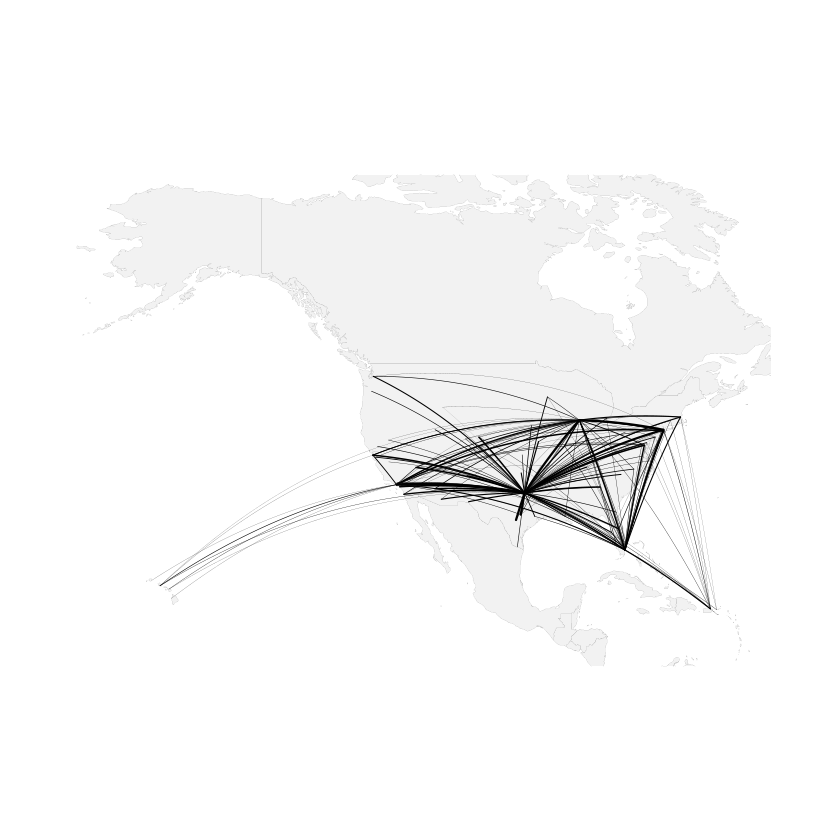

In [2]:
# airport codes and coordinates 
airports <- read.csv("../../../datasets/spatial/airports.csv", as.is=TRUE, header=TRUE)
# flight destinations and counts 
flights <- read.csv("../../../datasets/spatial/flights.csv", as.is=TRUE, header=TRUE)

airports$lat <- as.numeric(airports$lat)
airports$long <- as.numeric(airports$long)

head(airports)
head(flights)

# Draw world map in plain R 
map("world", col="#f2f2f2", fill=TRUE, bg="white", lwd=0.05, xlim=c(-172, -57), ylim=c(12, 72))

# This is needed to compute the great circle between two locations on earth 
library(geosphere)

# Display only American Airlines 
fsub <- flights[flights$airline == "AA",]

# go through each flight and find the coordinates of originating and destination airport 
for (j in 1:length(fsub$airline)) {
    air1 <- airports[airports$iata == fsub[j,]$airport1,]
    air2 <- airports[airports$iata == fsub[j,]$airport2,]

    # compute the great circle and create a path of 100 points between endpoints 
    inter <- data.frame(gcIntermediate(c(air1[1,]$long, air1[1,]$lat), c(air2[1,]$long, air2[1,]$lat), n=100, addStartEnd=TRUE))
    
    # draw the arc for this flight; line thickness encodes number of flights 
    lines(inter, col="black", lwd=2*fsub[j,]$cnt/max(fsub$cnt))
}

We can also read the vector map data from a **shapefile**. A shapefile contains geospatial vector data that define geometric shapes of a map and the related attributes. Shapefiles can be obtained from online resources such as [US Census Bureau](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html). We can read the shapefiles and convert them to data frames that ggplot can display. But they can be very large and take some time to process.

Regions defined for each Polygons


long,lat,order,hole,piece,id,group
-104.0534,41.17054,1,FALSE,1,0,0.1
-104.0532,41.19560,2,FALSE,1,0,0.1
-104.0532,41.19995,3,FALSE,1,0,0.1
-104.0527,41.27525,4,FALSE,1,0,0.1
-104.0526,41.27802,5,FALSE,1,0,0.1
-104.0525,41.27820,6,FALSE,1,0,0.1


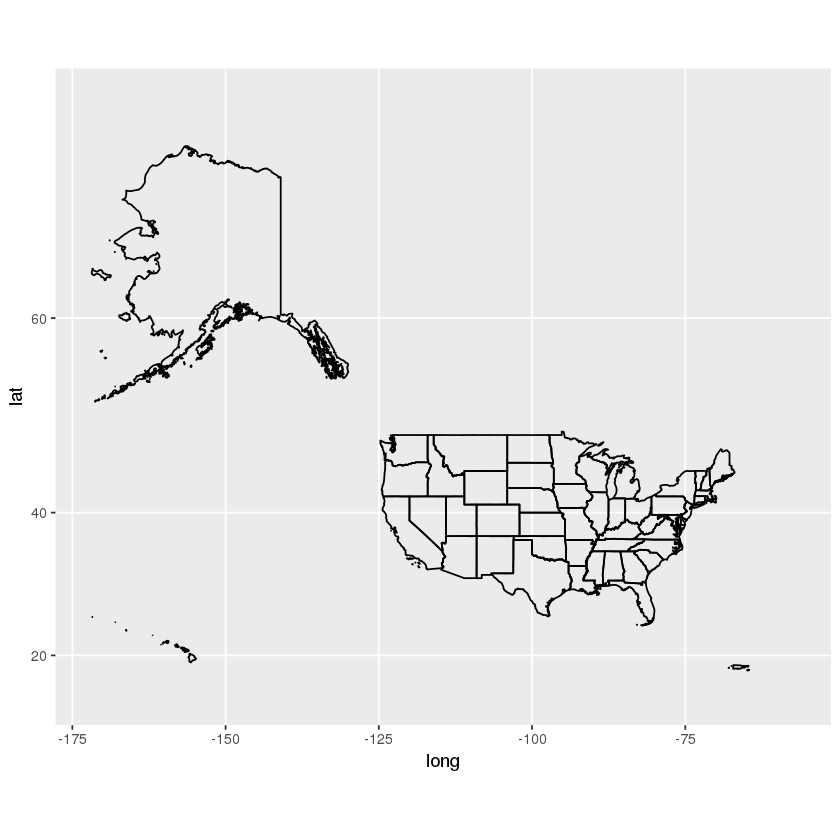

In [3]:
# Load the shapefile and convert to a data frame
us_shp <- readShapePoly("../../../datasets/spatial/cb_2015_us_state_500k.shp")
us_map <- fortify(us_shp)
head(us_map)

ggplot(us_map, aes(x = long, y = lat, group=group)) + 
geom_path() + 
coord_map("mercator") + 
xlim(c(-172, -57)) + ylim(c(12, 72)) 


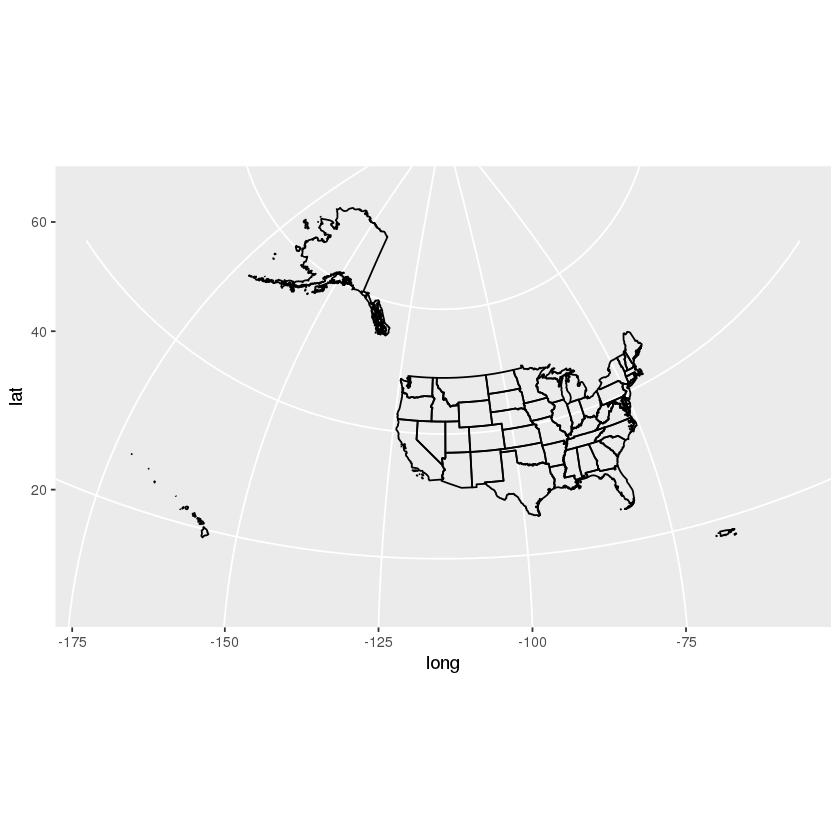

In [4]:
ggplot(us_map, aes(x = long, y = lat, group=group)) + 
geom_path() + 
coord_map("polyconic") + 
xlim(c(-172, -57)) + ylim(c(12, 72)) 

Let's see how to get the vector data using map_data() function of maps library. This will be faster. We will use this method to get vector map data. 

Warning message:
“Ignoring unknown aesthetics: x, y”

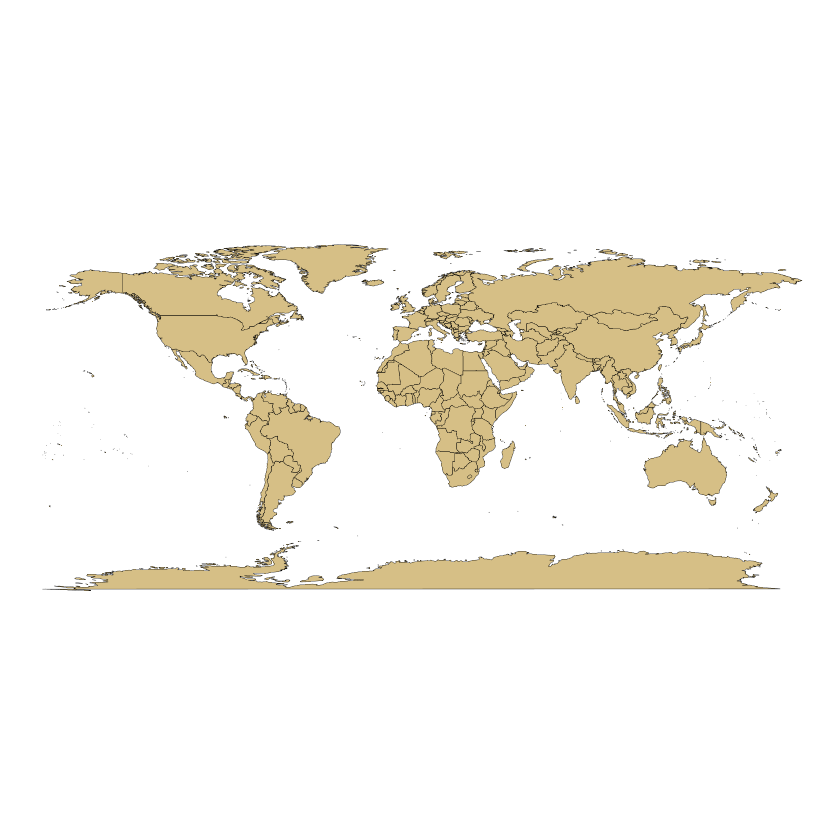

In [5]:
world <- map_data("world")
w <- ggplot()
w <- w + geom_map(data=world, map=world, aes(long, lat, map_id=region), color="black", fill="#d6bf86", size=0.1)
w <- w + coord_equal() 
w <- w + theme_void()
w

Warning message:
“Ignoring unknown aesthetics: x, y”

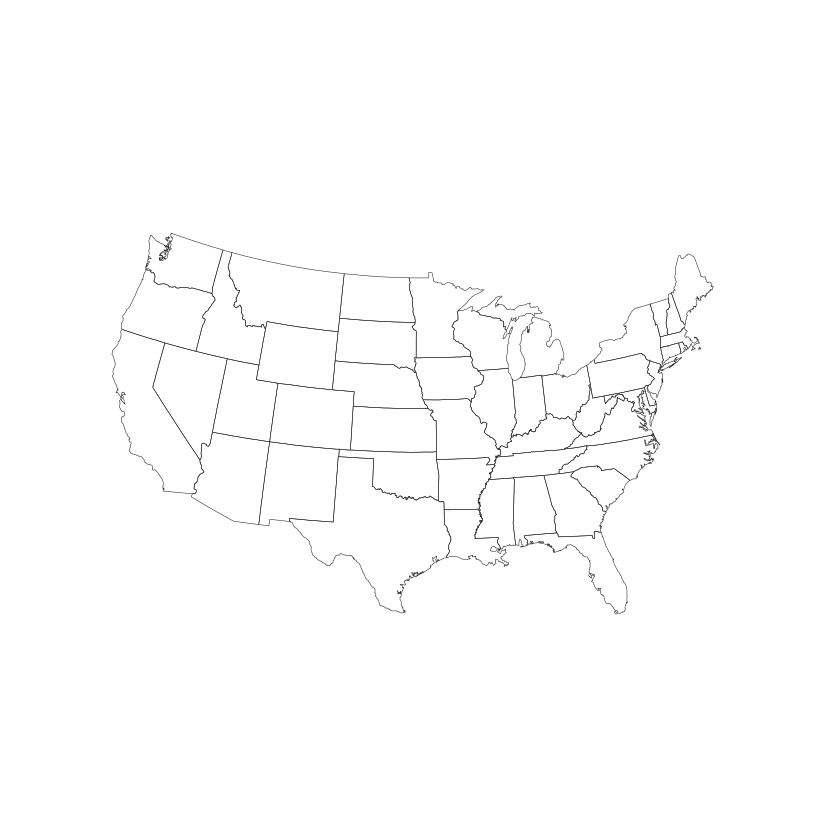

In [6]:
# We can similarly get the US state data 
us <- map_data("state")

gg <- ggplot() + geom_map(data=us, map=us, aes(long, lat, map_id=region), color="#222222", fill=NA, size=0.15)
# this is a good projection for US
gg <- gg + coord_map("polyconic")
gg <- gg + theme_void() 
gg 

Warning message:
“Ignoring unknown aesthetics: x, y”

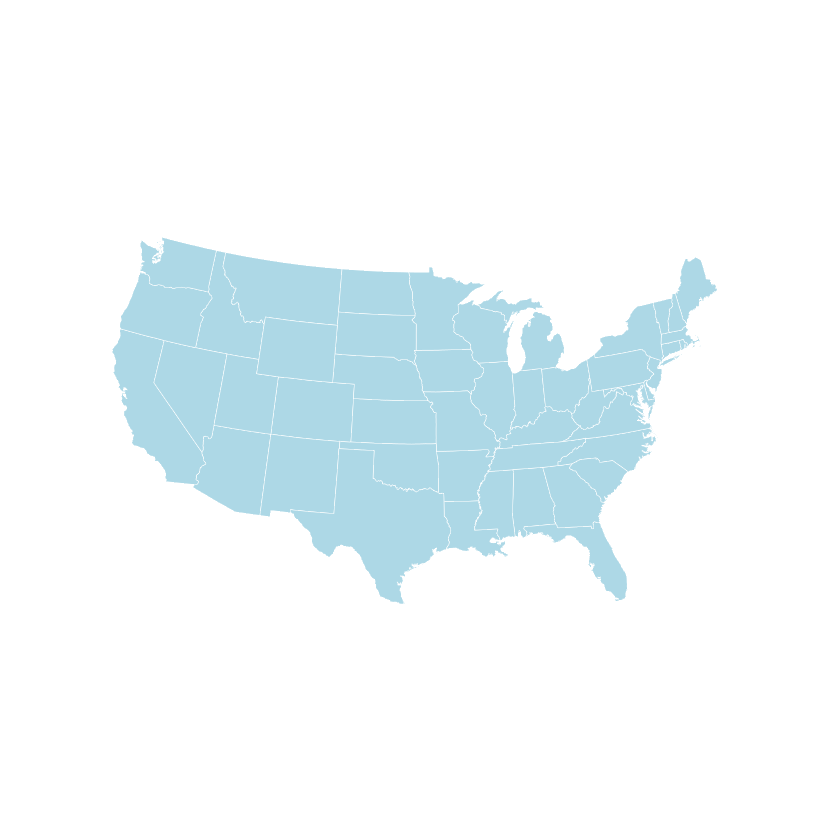

In [7]:
gg <- ggplot() + geom_map(data=us, map=us, aes(long, lat, map_id=region), color="white", fill="lightblue", size=0.15)
#This is better projection
gg <- gg + coord_map("albers", lat0=30, lat1=40)
gg <- gg + theme_void()
gg

Warning message:
“Ignoring unknown aesthetics: x, y”Warning message:
“Ignoring unknown aesthetics: x, y”Warning message:
“Ignoring unknown aesthetics: x, y”

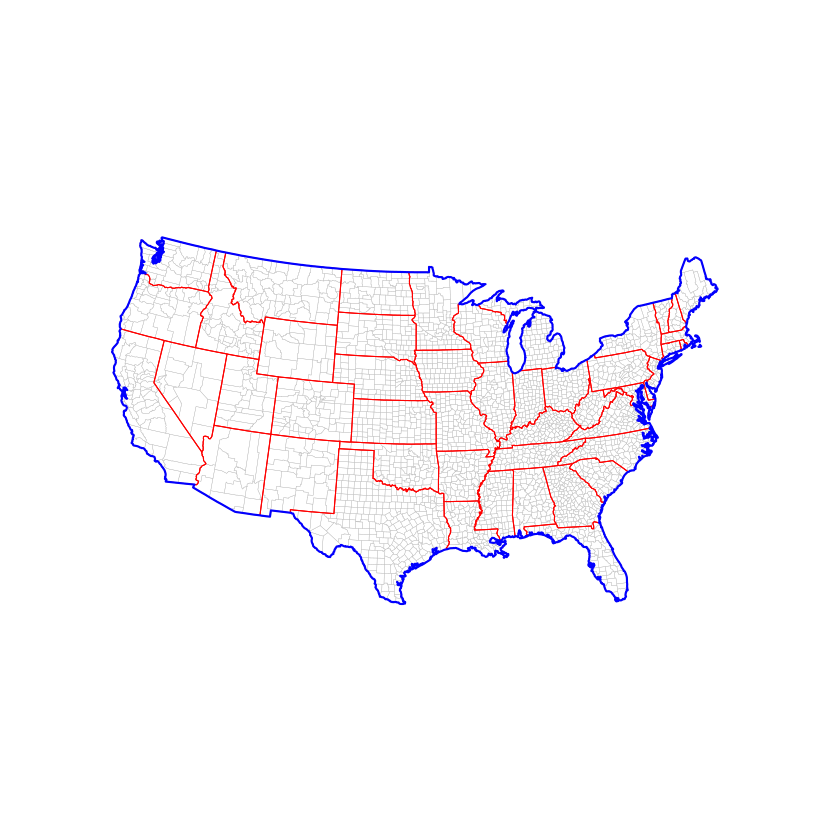

In [8]:
# This is how we can get data for different levels of detail and use different layers to overlay them. 

state <- map_data("state")
county <- map_data("county")
usa <- map_data("usa")

gg <- ggplot()
gg <- gg + geom_map(data=county, map=county,
                    aes(long, lat, map_id=region),
                    color="grey", fill=NA, size=0.1)
gg <- gg + geom_map(data=state, map=state,
                    aes(long, lat, map_id=region),
                    color="red", fill=NA, size=0.3)
gg <- gg + geom_map(data=usa, map=usa,
                    aes(long, lat, map_id=region),
                    color="blue", fill=NA, size=0.6)
gg <- gg + coord_map("albers", lat0=30, lat1=40)
gg <- gg + theme_void()
gg

In [9]:
head(county)

long,lat,group,order,region,subregion
-86.50517,32.34920,1,1,alabama,autauga
-86.53382,32.35493,1,2,alabama,autauga
-86.54527,32.36639,1,3,alabama,autauga
-86.55673,32.37785,1,4,alabama,autauga
-86.57966,32.38357,1,5,alabama,autauga
-86.59111,32.37785,1,6,alabama,autauga


In [10]:
#Let's pick Missouri
mo <- county[which(county$region=="missouri"),]

# same thing can be done like this:
mo2 <- map_data("county", "missouri")

# Let's select the Boone county from MO;  there are Boone counties in other states, too. 
boone <- county[which(county$subregion=="boone" & county$region=="missouri"),]


Warning message:
“Ignoring unknown aesthetics: x, y”Warning message:
“Ignoring unknown aesthetics: x, y”

,long,lat,group,order,region,subregion
43832,-92.67592,40.35342,1450,43832,missouri,adair
43833,-92.33215,40.35342,1450,43833,missouri,adair
43834,-92.33215,40.31331,1450,43834,missouri,adair
43835,-92.33215,40.04402,1450,43835,missouri,adair
43836,-92.84208,40.03829,1450,43836,missouri,adair
43837,-92.84208,40.34769,1450,43837,missouri,adair


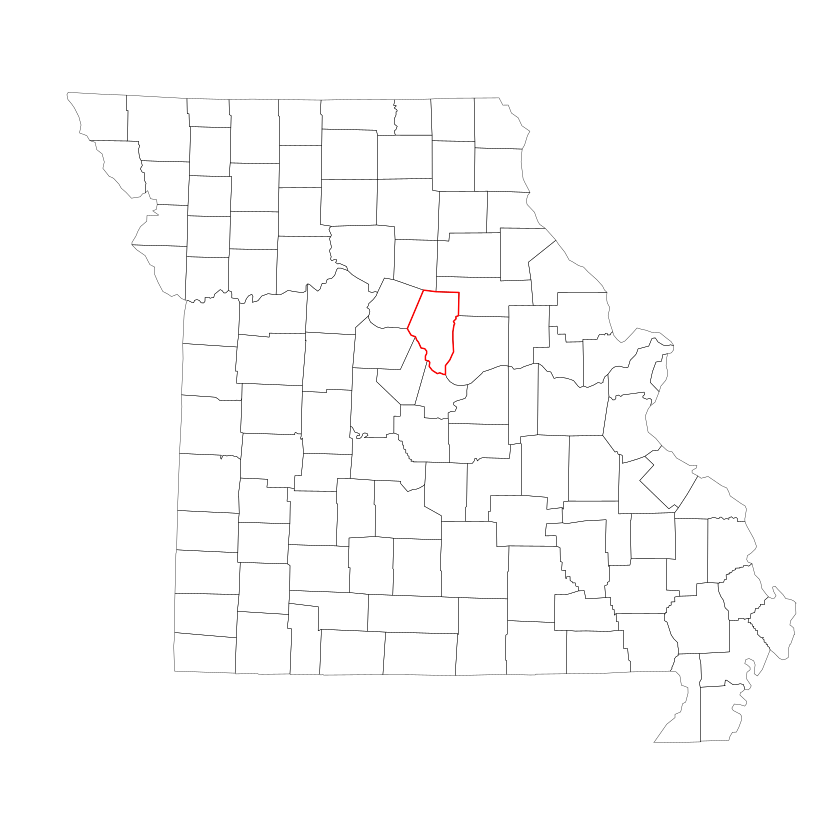

In [11]:
gg <- ggplot()
gg <- gg + geom_map(data=mo, map=mo,
                    aes(x=long, y=lat, map_id=region),
                    color="black", fill=NA, size=0.1)
gg <- gg + geom_map(data=boone, map=boone,
                    aes(x=long, y=lat, map_id=region),
                    color="red", fill=NA, size=0.4)
gg <- gg + coord_map("polyconic")

gg <- gg + theme_void()
gg
head(mo)

In [12]:
#In R, the which() function gives you the position of elements of a logical vector that are TRUE. It can be a row number or column number or position in a vector.


In [13]:
# Let's get coordinates of some of the cities in MO and display them. 
head(us.cities)
mo_cities <- us.cities[which(us.cities$country.etc=="MO"),]
mo_cities

name,country.etc,pop,lat,long,capital
Abilene TX,TX,113888,32.45,-99.74,0
Akron OH,OH,206634,41.08,-81.52,0
Alameda CA,CA,70069,37.77,-122.26,0
Albany GA,GA,75510,31.58,-84.18,0
Albany NY,NY,93576,42.67,-73.80,2
Albany OR,OR,45535,44.62,-123.09,0


,name,country.etc,pop,lat,long,capital
92,Blue Springs MO,MO,50116,39.02,-94.27,0
171,Chesterfield MO,MO,47202,38.65,-90.58,0
195,Columbia MO,MO,92756,38.95,-92.33,0
317,Florissant MO,MO,51644,38.80,-90.32,0
421,Independence MO,MO,110124,39.09,-94.35,0
435,Jefferson City MO,MO,39062,38.57,-92.19,2
440,Joplin MO,MO,47060,37.08,-94.50,0
445,Kansas City MO,MO,441833,39.12,-94.55,0
497,Lee's Summit MO,MO,83837,38.92,-94.38,0
639,O'Fallon MO,MO,79091,38.78,-90.71,0


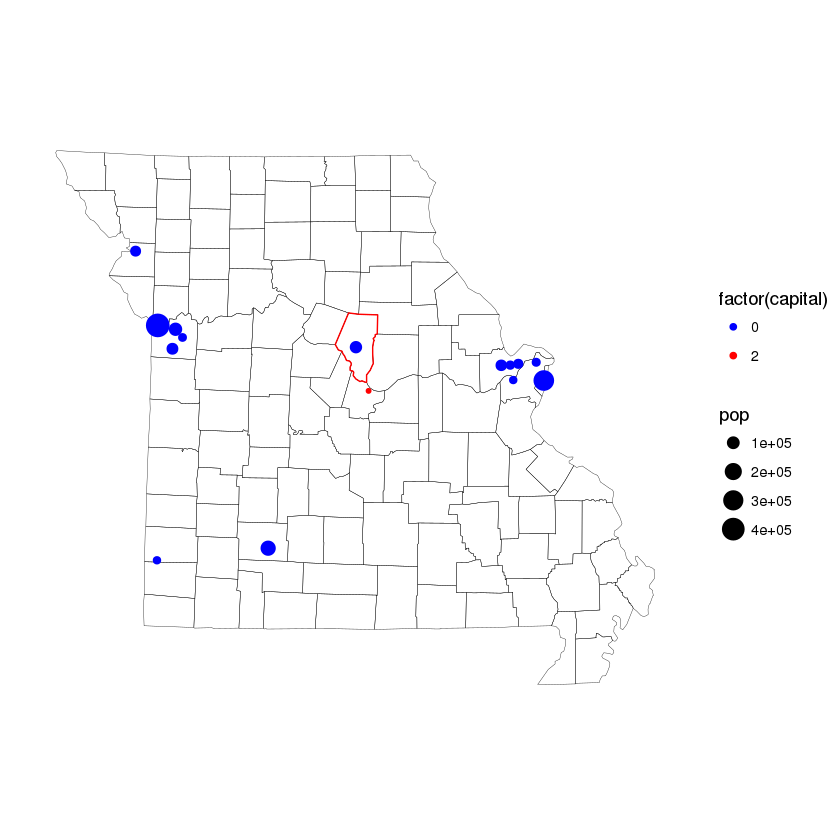

In [14]:
# This is a bubble map 
gg + geom_point(data=mo_cities, aes(x=long, y=lat, size=pop, color=factor(capital))) +
scale_color_manual(values=c("blue","red"))

Now, let's finish with a similar plot like in the beginning, but this time using ggplot and dplyr for smarter data manipulation.

airline,airport1,airport2,cnt,long.x,lat.x,long.y,lat.y
AA,MSP,DFW,326,-93.21692,44.88055,-97.03720,32.89595
AA,LGA,ORD,860,-73.87261,40.77724,-87.90446,41.97960
AA,PHX,DFW,550,-112.00806,33.43417,-97.03720,32.89595
AA,ORD,LAX,496,-87.90446,41.97960,-118.40807,33.94254
AA,ORD,DFW,825,-87.90446,41.97960,-97.03720,32.89595
AA,DEN,DFW,558,-104.66700,39.85841,-97.03720,32.89595


Warning message:
“Ignoring unknown aesthetics: x, y”Warning message:
“Removed 4 rows containing missing values (geom_curve).”

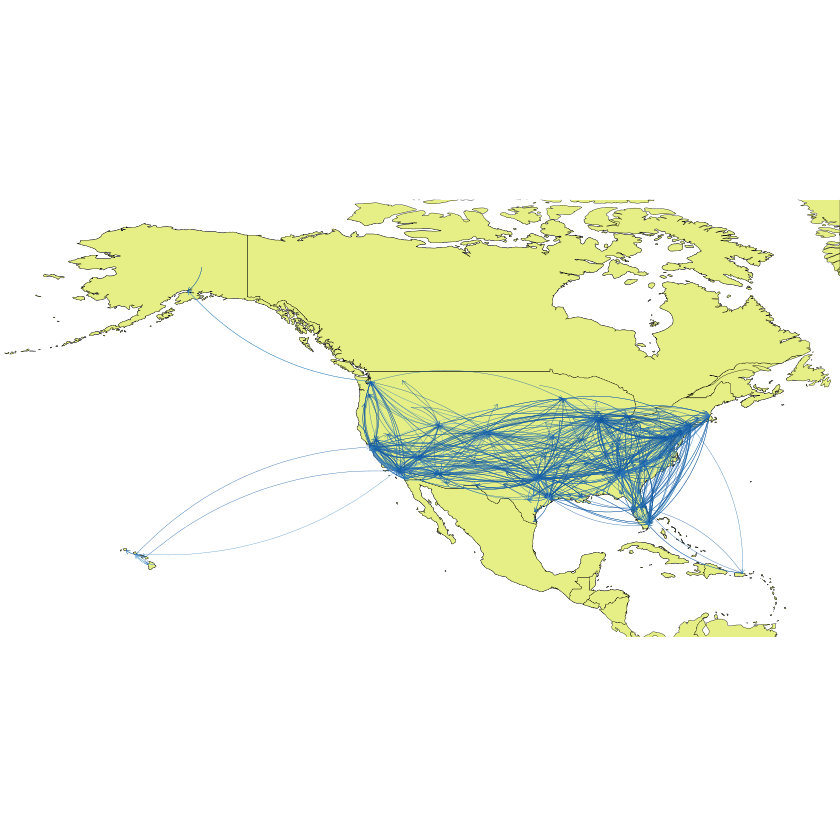

In [17]:
# pick only busy routes 
flights <- flights[which(flights$cnt> 300),]

# get airport locations
airport_locs <- airports[, c("iata","long", "lat")]

library(dplyr)
# Link airport lat long to origin and destination
OD <- left_join(flights, airport_locs, by=c("airport1"="iata"))
OD <- left_join(OD, airport_locs, by=c("airport2"="iata"))
head(OD)

# Now, create curves on the map with a fixed curvature - no great circle computation 
ggplot() + 
#geom_polygon(data=world, aes(long, lat, group=group), fill="#e6ef86", color="black", size=0.1) +
geom_map(data=world,map=world, aes(long, lat, map_id=region), fill="#e6ef86", color="black", size=0.1) +

geom_curve(data=OD, aes(x=long.x, y=lat.x, xend=long.y, yend=lat.y, color=cnt), size=0.1,
                 curvature=-0.2, arrow=arrow(length=unit(0.01, "npc"))) +
    
scale_colour_distiller(palette="Blues", guide="none") +
coord_equal() +
xlim(c(-172,-57)) + ylim(c(12,72)) + 
theme_void()